In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import infercnvpy as cnv
import matplotlib

import sys
sys.path.append("../..")
import insitucnv as icv

/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read adata

In [2]:
saving_path='/media/sergio/GBX/5KXenium/simulated'
adata=sc.read(os.path.join(saving_path,'lung_organoids_cnvclust0_simulatedCNVs_121224_simulationv2_rho6_subsampled.h5ad'))

## Compute similarity between simulated subclone and CNV_leiden

We use adjusted rand index (ARI) and normalized mutual info (NMI) to compute similarity between simulated subclones and computed subclones

In [3]:
ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key='cnv_leiden_res0.7')
nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key='cnv_leiden_res0.7')

print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")


Adjusted Rand Index (ARI): 0.4945156421017969
Normalized Mutual Information (NMI): 0.44199964430094596


### (temporary step, compute cnv inference, including calculate_gene_values=True, so that we can compare)

In [4]:
cnv.tl.infercnv(adata, reference_key=None, reference_cat=None, reference=None, lfc_clip=3, window_size=100, step=10, dynamic_threshold=1.5, exclude_chromosomes=('chrX', 'chrY'), chunksize=5000, n_jobs=None, inplace=True, layer=None, key_added='cnv', calculate_gene_values=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:02<00:00, 302.96s/it]


# CNV predictability

In [6]:
cnv_score_in_gains=cnv_values[ground_truth==1]
cnv_score_in_gains=[x for x in cnv_score_in_gains if str(x) != 'nan']
cnv_score_in_losses=cnv_values[ground_truth==-1]
cnv_score_in_losses=[x for x in cnv_score_in_losses if str(x) != 'nan']
cnv_score_in_neutrals=cnv_values[ground_truth==0]
cnv_score_in_cnv=cnv_values[ground_truth!=0]
cnv_score_in_cnv=[x for x in cnv_score_in_cnv if str(x) != 'nan']
cnv_score_in_neutrals=[x for x in cnv_score_in_neutrals if str(x) != 'nan']

In [7]:
true_gains=len([e for e in cnv_score_in_gains if e>0])/len(cnv_score_in_gains)
true_losses=len([e for e in cnv_score_in_losses if e<0])/len(cnv_score_in_losses)

In [8]:
true_neutrals=np.sum(np.abs(cnv_score_in_neutrals)==0)/len(cnv_score_in_neutrals)
true_cnv=np.sum(np.abs(cnv_score_in_cnv)!=0)/len(cnv_score_in_cnv)
false_neutrals=1-true_neutrals
false_cnv=1-true_cnv

Accuracy = (True positives + True Negatives)/ (True positives + True negatives + False positives + False negatives)

In [10]:
## metrics for CNV gain and loss together
results_all = icv.tl.compute_performance_metrics(true_cnv, false_neutrals, true_neutrals, false_cnv)

## metrics for CNV gain
results_gain = icv.tl.compute_performance_metrics(true_gains, false_neutrals, true_neutrals,1- true_gains)

## metrics for CNV loss
results_loss = icv.tl.compute_performance_metrics(true_losses, false_neutrals, true_neutrals,1- true_losses)

### Specially relevant for our case are the F1 scores

In [13]:
results_all['F1 Score']

0.4381419401116141

# We can also compute AUC & PR

In [12]:
ground_truth=adata.layers['CNV_GT']
cnv_values=adata.layers["gene_values_cnv"]

# Example data
simulated = ground_truth.flatten()  # Simulated CNVs for a gene (0: neutral, 1: gain, -1: loss)
inferred_scores = cnv_values.flatten()  # Inferred scores for the same gene

filter_nan = [str(x) != 'nan' for x in inferred_scores]

simulated = simulated[filter_nan]
inferred_scores = inferred_scores[filter_nan]

# Compute AUC for gains (class_value = 1) and losses (class_value = -1)
roc_auc_gains, pr_auc_gains = icv.tl.compute_auc(simulated, inferred_scores, 1)
roc_auc_losses, pr_auc_losses = icv.tl.compute_auc(simulated, inferred_scores, -1)

# Print results
print(f"ROC AUC for Gains: {roc_auc_gains:.3f}")
print(f"PR AUC for Gains: {pr_auc_gains:.3f}")
print(f"ROC AUC for Losses: {roc_auc_losses:.3f}")
print(f"PR AUC for Losses: {pr_auc_losses:.3f}")


ROC AUC for Gains: 0.693
PR AUC for Gains: 0.045
ROC AUC for Losses: 0.513
PR AUC for Losses: 0.002


###  Turn it into a per  per gene accuracy metric

In [14]:
affected_genes_info=adata.var.loc[np.sum(np.abs(ground_truth),axis=0)>0,:]
affected_genes_values=cnv_values[:,np.sum(np.abs(ground_truth),axis=0)>0]
affected_genes_ground_truth=ground_truth[:,np.sum(np.abs(ground_truth),axis=0)>0]

In [15]:
from tqdm import tqdm 

simulated_matrix = affected_genes_ground_truth  # Simulated CNVs for multiple genes (cells x genes)
inferred_scores_matrix = affected_genes_values  # Inferred CNV scores for the same genes (cells x genes)

# Initialize lists to store AUC scores per gene
roc_auc_gains_per_gene = []
pr_auc_gains_per_gene = []
roc_auc_losses_per_gene = []
pr_auc_losses_per_gene = []

# Iterate through each gene (columns)
num_genes = simulated_matrix.shape[1]
for g in tqdm(range(num_genes)):
    # Flatten the current gene's data (simulated and inferred scores for all cells)
    simulated = simulated_matrix[:, g].flatten()
    inferred_scores = inferred_scores_matrix[:, g].flatten()

    # Filter out NaN values
    filter_nan = [str(x) != 'nan' for x in inferred_scores]
    simulated = simulated[filter_nan]
    inferred_scores = inferred_scores[filter_nan]
    
    # Compute AUC for gains (class_value = 1) and losses (class_value = -1) for the current gene
    if 1 in np.unique(simulated).astype(int):
        roc_auc_gains, pr_auc_gains = icv.tl.compute_auc(simulated, inferred_scores, 1.0)
        roc_auc_gains_per_gene.append(roc_auc_gains)
        pr_auc_gains_per_gene.append(pr_auc_gains)
    else:
        roc_auc_gains_per_gene.append(np.nan)
        pr_auc_gains_per_gene.append(np.nan)
    
    if -1 in np.unique(simulated).astype(int):
        roc_auc_losses, pr_auc_losses = icv.tl.compute_auc(simulated, inferred_scores, -1.0)
        roc_auc_losses_per_gene.append(roc_auc_losses)
        pr_auc_losses_per_gene.append(pr_auc_losses)
    else:
        roc_auc_losses_per_gene.append(np.nan)
        pr_auc_losses_per_gene.append(np.nan)

100%|████████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 355.77it/s]


<Axes: >

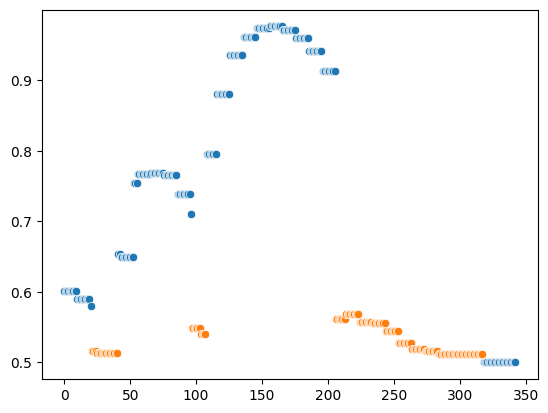

In [16]:
sns.scatterplot(roc_auc_gains_per_gene)
sns.scatterplot(roc_auc_losses_per_gene)

# APPLYING METRICS: Downsampling effect

In [27]:
layers=['subsampling_70','subsampling_20','subsampling_5','subsampling_1']

In [30]:
sc.pp.subsample(adata,0.1)

In [49]:
adata

AnnData object with n_obs × n_vars = 126 × 25691
    obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'model_id', 'sample_id', 'Phase', 'level_1', 'level_2', 'level_3', 'CountUMIs', 'CountGenes', 'X.Mitochondrial', 'NoveltyScore', 'nCount_SCT', 'nFeature_SCT', 'orig.ident', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cnv_leiden', 'simulated_subclone', 'cnv_score', 'cnv_leiden_res0.1', 'cnv_leiden_res0.15', 'cnv_leiden_res0.2', 'cnv

In [50]:
roc_gain_all=[]
roc_loss_all=[]
ari_all=[]
nmi_all=[]
for la in layers:
    cnv.tl.infercnv(adata, reference_key="simulated_subclone",reference_cat="N",
    window_size=100,layer=la, key_added='cnv_'+la, calculate_gene_values=True)
    
    ground_truth=adata.layers['CNV_GT']
    cnv_values=adata.layers["gene_values_cnv_"+la]
    # Example data
    simulated = ground_truth.flatten()  # Simulated CNVs for a gene (0: neutral, 1: gain, -1: loss)
    inferred_scores = cnv_values.flatten()  # Inferred scores for the same gene
    # filter_nan
    filter_nan = [str(x) != 'nan' for x in inferred_scores]

    simulated = simulated[filter_nan]
    inferred_scores = inferred_scores[filter_nan]

    # Compute AUC for gains (class_value = 1) and losses (class_value = -1)
    roc_auc_gains, pr_auc_gains = icv.tl.compute_auc(simulated, inferred_scores, 1)
    roc_auc_losses, pr_auc_losses = icv.tl.compute_auc(simulated, inferred_scores, -1)
    roc_gain_all.append(roc_auc_gains)
    roc_loss_all.append(roc_auc_losses)
    
    # cnv clustering
    cnv.tl.pca(adata,use_rep="X_cnv_"+la)
    resol=0.7
    cnv.pp.neighbors(adata)
    cnv.tl.leiden(adata, resolution=resol,key_added='cnv_leien_'+la)
    while len(np.unique(adata.obs['cnv_leiden']))!=4:
        if len(np.unique(adata.obs['cnv_leiden']))<4:
            resol=resol+0.1
        if len(np.unique(adata.obs['cnv_leiden']))>4:
            resol=resol-0.1
        cnv.tl.leiden(adata, resolution=resol,key_added='cnv_leien_'+la)    
    ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key='cnv_leien_'+la)
    nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key='cnv_leien_'+la)
    # 
    ari_all.append(ari)
    nmi_all.append(nmi)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.57s/it]


KeyError: 'X_X_cnv_subsampling_70 is not in adata.obsm. Did you run `tl.infercnv`?'

# Visualize results

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'losses')

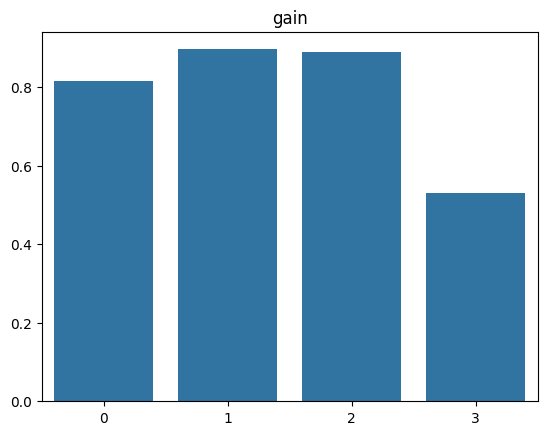

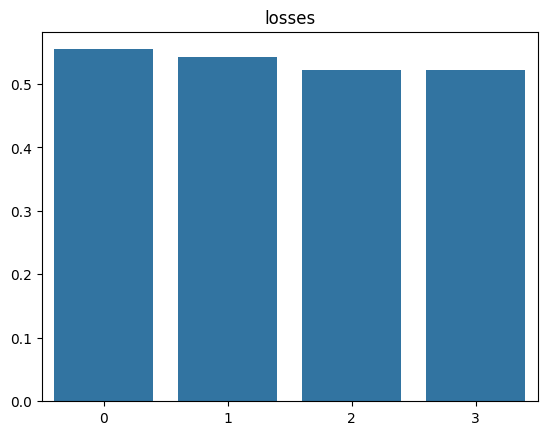

In [43]:
plt.figure()
sns.barplot(roc_gain_all)
plt.title('gain')
plt.figure()
sns.barplot(roc_loss_all)
plt.title('losses')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'nmi')

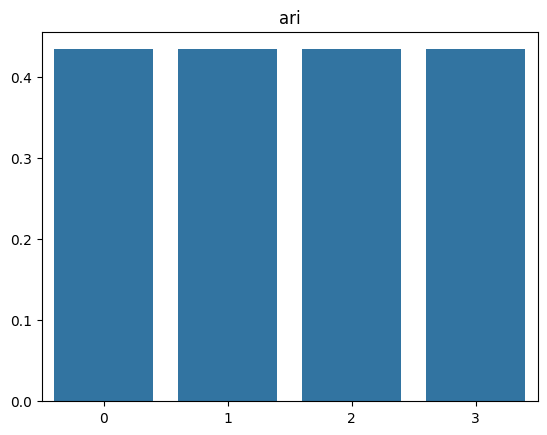

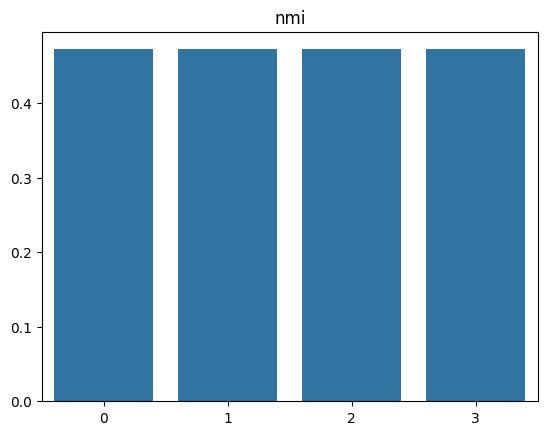

In [45]:
plt.figure()
sns.barplot(ari_all)
plt.title('ari')
plt.figure()
sns.barplot(nmi_all)
plt.title('nmi')

In [23]:
np.sum(adata.layers['subsampling_20'].todense())

3317571.8

# Matching matrices

In [ ]:
def get_ref_points(adata:'AnnData'):
    '''Function to get the chromosomal position/ref_points for each position where CNVs have been inferred
    Params:
        adata(AnnData): anndata where CNVs have been inferred using inferCNVs
    Output:
        refpoints(DataFrame): DataFrame indicating the chromosomal position of each ref_point.
        Note that each ref_point is, actually, the position of one of the genes included in the panel. Thus, they also have the game of the gene.
    '''
    allinfo=[]
    for k in adata.uns['cnv']['chr_pos'].keys():
        pos=adata.uns['cnv']['chr_pos'][k]
        try:
            posmax=adata.uns['cnv']['chr_pos']['chr'+str(int(k[3:])+1)]
            chromopos=adata.obsm['X_cnv'][:,pos:posmax]
        except:
            chromopos=adata.obsm['X_cnv'][:,pos:]
        chrom=adata.var[adata.var['chromosome']==k].copy()
        windowsize=100
        step=10
        startpos=0#int(windowsize/2)
        listofg=[]
        listofpos=[]
        listofchr=[]
        if chrom.shape[0]>windowsize:
            while startpos<chrom.shape[0]:
            #    print(startpos)
                anchor_info=chrom.iloc[startpos,:]
                startpos=startpos+step
                listofg.append(anchor_info['gene_symbols'])
                listofpos.append(anchor_info['start'])
                listofchr.append(anchor_info['chromosome'])
        else:
            anchor_info=chrom.iloc[int(chrom.shape[0]/2),:]
            listofg.append(anchor_info['gene_symbols'])
            listofpos.append(anchor_info['start'])
            listofchr.append(anchor_info['chromosome'])
        combinedinfo=pd.DataFrame([listofg,listofpos,listofchr]).transpose()
        allinfo.append(combinedinfo)
    refpoints=pd.concat(allinfo)
    return refpoints

def find_closest_numbers(list1, list2):
    '''Find the closest number in list 2 for each number in list 1
    Params:
        list1(list): list of numbers, coordinates in this case
        list2(list): list of numbers, coordinates in this case
    Output:
        closest_numbers(list): for each element in list 1, closest number in list 2
    '''
    closest_numbers = []
    for num in list1:
        closest_num = min(list2, key=lambda x: abs(x - num))
        closest_numbers.append(closest_num)
    return closest_numbers

def match_CNV_matrices(adata='adata',adata_1k='adata_1k'):
    ''' Given two anndata datasets, where CNVs have been predicted using inferCNV, match the closest refpoints between both matices.
    For the smallest adata (less genes), a larger CNV matrix with the size of the larger CNV matrix is created.
    Each column is filled with the CNV value obtained from the closest ref_point (in chromosomal position) in each given cell.
    This is done to ensure datasets are comparable.
    Params:
        adata_1k: adata containing the infered cnvs with less genes
        adata: adata containig the infered cnvs with more genes
    Output:
        adata_1k: adata containing the infered cnvs with less genes and the new matrix, matching the size of the inferred CNV matrix in adata
        adata: adata containig the infered cnvs with more genes
        refpoints_mapped:dataframe containing the mapping between the reference points of the two matrices and their distances.
    
    '''
    # extract anchor_points/ref_points
    refpoints=get_ref_points(adata)
    refpoints_1k=get_ref_points(adata_1k)
    second_infer=adata_1k.obsm['X_cnv'].todense()
    original_infer=adata.obsm['X_cnv'].todense()
    # reset indices (very important for consistency)
    refpoints_1k=refpoints_1k.reset_index()
    refpoints=refpoints.reset_index()
    # define unique chromosomes
    chromosomes=np.unique(refpoints[2])
    allg=[]
    # for each chromosome, find the closest anchor points of methods 1 in method 2
    for c in chromosomes:
        r1=refpoints[refpoints[2]==c]
        r2=refpoints_1k[refpoints_1k[2]==c]
        dict2gene=dict(zip(r2[1],r2[0]))
        dict2index=dict(zip(r2[1],r2.index))
        gg=find_closest_numbers(r1[1], r2[1])
        r1['closest_position']=gg
        r1['closest_gene']=[dict2gene[g] for g in gg]
        r1['closest_index']=[dict2index[g] for g in gg]
        allg.append(r1)
    # next we concatenate all 
    refpoints_mapped=pd.concat(allg)
    # finally, we make a new matrix with has (1)the same dimensions as the CNV matrix in method 1 and 
    #(2) on each column, we add the values of the closest anchor point of matrix 2
    modified_CNVs=second_infer[:,list(refpoints_mapped.loc[:,'closest_index'])]  # we store this on adata_1k.obs['X_cnv_adapted']
    adata_1k.obsm['X_cnv_adapted']=modified_CNVs
    refpoints_mapped['bp_distance']=abs(refpoints_mapped[1]-refpoints_mapped['closest_position'])
    return adata,adata_1k,refpoints_mapped

def plot_refpoints_distance(refpoints_mapped,max_distance_threshold=100000):
    ''' Plot the distance between anchor points
    Params:
       refpoints_mapped:dataframe containing the mapping between the reference points of the two matrices
       max_distance_threshold(int): max distance allowed between refpoints to keep them in the analysis
    '''
    bns=plt.hist(refpoints_mapped['bp_distance'],bins=2000)
    plt.xscale('log')
    plt.xlabel('distance between anchors')
    plt.ylabel('number of anchors')
    plt.axvline(x = max_distance_threshold, color = 'r', label = 'axvline - full height')
    
def filter_scores_by_distance(adata_1k:'AnnData',adata:'AnnData',refpoints_mapped:'DataFrame',max_distance_threshold:int=50000):
    ''' Filter CNV scores by distance between refpoints, keeping only the ones, situated at a distance closer than the threshold selected
    Params:
        adata_1k: adata containing the infered cnvs with less genes
        adata: adata containig the infered cnvs with more genes
        refpoints_mapped:dataframe containing the mapping between the reference points of the two matrices
        max_distance_threshold(int): max distance allowed between refpoints to keep them in the analysis
    Output:
        original_infer: matrix (from the largest dataset) containing the inferred CNVs for the refpoints situated at less than the max_distance_threshold
        adapted_infer: matrix (from the smallest dataset) containing the inferred CNVs for the refpoints situated at less than the max_distance_threshold
    
    '''
    filter_distance=refpoints_mapped['bp_distance']<max_distance_threshold
    adapted_infer=adata_1k.obsm['X_cnv_adapted'][:,filter_distance]
    original_infer=adata.obsm['X_cnv'].todense()[:,filter_distance]
    return original_infer,adapted_infer

def plot_ref_points_by_chromosome(refpoints_mapped:'DataFrame',figsize=(12,12),cmap='viridis'):
    '''Plot, as scatterpoint, the chromosomal position of the ref_points used in dataset 1 (x-axis) and dataset 2 (y-axis)
    Arguments:
        refpoints_mapped('DataFrame'):dataframe obtained from 'match_CNV_matrices' where the relation between the ref_points of the two runs are compared
    '''
    chromosomes=np.unique(refpoints_mapped[2])
    e=1
    plt.figure(figsize=figsize)
    for c in chromosomes:
        plt.subplot(5,5,e)
        rf=refpoints_mapped[refpoints_mapped[2]==c]
        plt.scatter(rf[1],rf['closest_position'],c=rf['bp_distance'],s=10,cmap=cmap)
        plt.title(c)
        plt.xlabel('Position in run 1')
        plt.ylabel('Position in run 2')
        e=e+1
    plt.tight_layout()
    
    

In [41]:
adata,adata_1k,refpoints_mapped=match_CNV_matrices(adata=adata,adata_1k=adata)

IndexError: index 2274 is out of bounds for axis 1 with size 2274

In [28]:
adata.layers['CNV_GT'].shape

(1268, 25691)

In [36]:
adata.var

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,chromosome,start,end
gene_ids,,,,,,,,,,,,,,,,
ENSG00000238009,AL627309.1,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,486,0.008812,0.008774,94.534413,78.360051,4.373995,chr1,89295.0,133566.0
ENSG00000241860,AL627309.5,False,ENSG00000241860.7,NCBITaxon:9606,gene,1025,lncRNA,581,0.010553,0.010498,93.466037,93.837299,4.552163,chr1,141474.0,173862.0
ENSG00000241599,AL627309.4,False,ENSG00000241599.1,NCBITaxon:9606,gene,457,lncRNA,7,0.000246,0.000246,99.921278,2.190479,1.160171,chr1,160446.0,161525.0
ENSG00000286448,AP006222.2,False,ENSG00000286448.1,NCBITaxon:9606,gene,736,lncRNA,45,0.000741,0.000740,99.493927,6.585102,2.026186,chr1,266855.0,268655.0
ENSG00000237491,LINC01409,False,LINC01409,NCBITaxon:9606,gene,1059,lncRNA,1591,0.035527,0.034910,82.107512,315.902356,5.758594,chr1,778747.0,810065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000158639,PAGE5,False,PAGE5,NCBITaxon:9606,gene,553,protein_coding,18,0.000335,0.000335,99.797571,2.976101,1.380302,NaN,NaN,NaN
ENSG00000269437,NXF2B,False,NXF2B,NCBITaxon:9606,gene,2143,protein_coding,12,0.000327,0.000327,99.865047,2.905183,1.362305,NaN,NaN,NaN
ENSG00000204025,TRPC5OS,False,TRPC5OS,NCBITaxon:9606,gene,2779,protein_coding,11,0.000238,0.000238,99.876293,2.112197,1.135329,NaN,NaN,NaN


In [33]:
adata.layers['subsampling_1']

<1268x25691 sparse matrix of type '<class 'numpy.float32'>'
	with 358275 stored elements in Compressed Sparse Row format>

In [31]:
adata.obsm['X_cnv'].shape

(1268, 2274)

In [15]:
adata.layers['CNV_simulated']

0.0

In [11]:
adata.layers['CNV_simulated'].max()

8.553583